In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [53]:
data = pd.read_csv('doge_data_1_min.csv')
df = data[['close_time', 'close']]
price_data = df.to_numpy()

print(price_data.shape)

(119521, 2)


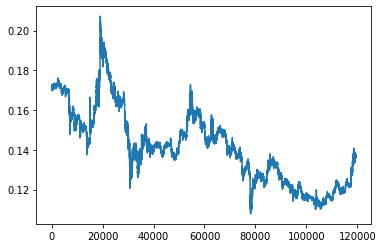

In [54]:
plt.plot(price_data[:, 1])
plt.show()

In [93]:
def get_trades(price_arr, short, take_profit_percentage, selling_points, starting_balance=500, starting_stake=100, compound=False):
    # selling_points => (open_period >=, sell_at_loss_percentage)
    trades = []
    trade_buy_time = -1
    trade_buy_price = -1
    i = 0

    current_balance = starting_balance  # This cannot be negative at any point of time
    current_stake = starting_stake
    open_trades = []
    open_period = 0
    profit_loss = 0

    trades_on_hold = []

    for row in price_arr:
        i += 1

        # Open a new trade if possible
        if trade_buy_time == -1 and current_balance >= current_stake:
            trade_buy_time = row[0]
            trade_buy_price = row[1]
            open_trades.append([trade_buy_time, current_stake])

            # reduce the stake amount from current balance
            current_balance -= current_stake


        if trade_buy_time != -1:
            open_period = (datetime.fromtimestamp(row[0] / 1000.0) - datetime.fromtimestamp(
                trade_buy_time / 1000.0)).total_seconds() / 86400
            profit_loss = (row[1] - trade_buy_price) * 100 / trade_buy_price

        if short:
            profit_loss = -profit_loss

        # Profit loop
        if profit_loss >= take_profit_percentage:
            trade_sell_time = row[0]
            trade_sell_price = row[1]

            # open_trades.remove([trade_buy_time])
            # open_trades_history.append(len(open_trades))

            # add the profit amount to stake amount
            profit_loss_abs = current_stake * profit_loss / 100
            current_balance += (current_stake + profit_loss_abs)
            if compound:
                current_stake += profit_loss_abs  # This is like re-investing profits

            trades.append(
                [trade_buy_time, trade_buy_price, trade_sell_time, trade_sell_price, profit_loss_abs, current_balance])
            trade_buy_time = -1
            trade_buy_price = -1
            open_period = 0
            skip_until = i + 0

        # Loss loop
        if len(trades_on_hold) > 0:
            trade, trades_on_hold, p_l = try_to_sell_hold_trades(trades_on_hold, row, selling_points, short)
            if trade is not None:
                trade_sell_time = row[0]
                trade_sell_price = row[1]

                # open_trades.remove([trade[0]])
                # open_trades_history.append(len(open_trades))

                # add the profit amount to stake amount
                profit_loss_abs = trade[2] * p_l / 100
                current_balance += (trade[2] + profit_loss_abs)  # Assuming profit_loss_abs is negative
                trades.append([trade[0], trade[1], trade_sell_time, trade_sell_price, profit_loss_abs, current_balance])

        for period, _ in selling_points:
            if open_period >= period:
                # Add the trade to the list of trades on hold
                trades_on_hold.append([trade_buy_time, trade_buy_price, current_stake])

                # Open a new trade
                trade_buy_time = -1
                trade_buy_price = -1
                open_period = 0

                # current_stake_amount = starting_stake
                break

    print("Current balance: ", current_balance)

    open_trades_amount = 0
    for trade in open_trades:
        if trade[0] not in np.array(trades)[:, 0]:
            open_trades_amount += trade[1]
    print("Sum of current invested amount: ", open_trades_amount)

    return np.array(trades), trade_buy_time, trade_buy_price, trades_on_hold

def try_to_sell_hold_trades(trades_on_hold, row, selling_points, short):
    profit_loss = 0
    for trade in trades_on_hold:
        profit_loss = (row[1] - trade[1]) * 100 / trade[1]
        open_period = (datetime.fromtimestamp(row[0] / 1000.0) - datetime.fromtimestamp(
            trade[0] / 1000.0)).total_seconds() / 86400
        if short:
            profit_loss = -profit_loss
        # For now, I'm assuming it's only loss and only one trade on hold at a time.
        for period, stop_loss_percentage in selling_points:
            if open_period >= period and -profit_loss <= stop_loss_percentage:
                trades_on_hold.remove(trade)
                return trade, trades_on_hold, profit_loss
    return None, trades_on_hold, profit_loss

In [15]:
total_trading_period = (datetime.fromtimestamp(price_data[-1, 0] / 1000.0) - datetime.fromtimestamp(
        price_data[0, 0] / 1000.0)).total_seconds() / 86400

def summarize_trades(get_trades_out):
    trades, trade_buy_time, trade_buy_price, trades_on_hold = get_trades_out[0], get_trades_out[1], get_trades_out[2], get_trades_out[3]
    print('total profit is', trades[:, 4].sum())
    print('Average profit per day is', trades[:, 4].sum() / total_trading_period)
    print('No. of trades', len(trades))
    print('Average trade period is', trades[:, 5].sum() / len(trades))
    print('Min trade period is', np.min(trades[:, 5]))
    print('Max trade period is', np.max(trades[:, 5]))
    print('No. of trades on hold', len(trades_on_hold))
    print('\n')

    if trade_buy_time != -1:
        hold_period = datetime.fromtimestamp(price_data[-1, 0] / 1000.0) - datetime.fromtimestamp(trade_buy_time / 1000.0)
        print('Last buy time', datetime.fromtimestamp(trade_buy_time / 1000.0))
        print('Last buy price', trade_buy_price)
        print('Hold period since the last buy time', hold_period)

    print('\n')
    calculate_compound_returns(trades)

def calculate_compound_returns(trades):
    initial_amount = 100
    profit = initial_amount
    for trade in trades:
        profit += profit * trade[4] / 100

    print('Total compounded profit percentage is', (profit - initial_amount))
    print('Average profit per day is', (profit - initial_amount) / total_trading_period)

In [94]:
a = get_trades(price_arr=price_data, short=0, take_profit_percentage=1, selling_points=[(2, 3), (5, 7)], compound=False)
summarize_trades(a)

Current balance:  251.85473601659533
Sum of current invested amount:  300
total profit is 51.85473601659528
Average profit per day is 0.22948804432939088
No. of trades 139
Average trade period is 304.865602317772
Min trade period is 130.36136269903568
Max trade period is 530.3361228294168
No. of trades on hold 2


Last buy time 2022-03-24 09:57:59.999000
Last buy price 0.1405
Hold period since the last buy time 14:03:00


Total compounded profit percentage is 61.541157785847275
Average profit per day is 0.2723562210695804


In [92]:
b = get_trades(price_arr=price_data, short=1, take_profit_percentage=1, selling_points=[(2, 3), (5, 7)], compound=True)
summarize_trades(b)

Current balance:  1084.863161002872
Sum of current invested amount:  765.0050916815701
total profit is 372.34330897218206
Average profit per day is 1.647840570778604
No. of trades 165
Average trade period is 0.9232996632996633
Min trade period is 0.0
Max trade period is 30.492361111111112
No. of trades on hold 0


Last buy time 2022-03-23 01:05:59.999000
Last buy price 0.1214
Hold period since the last buy time 1 day, 22:55:00


Total compounded profit percentage is 2176.8338628988504
Average profit per day is 9.633784383103892


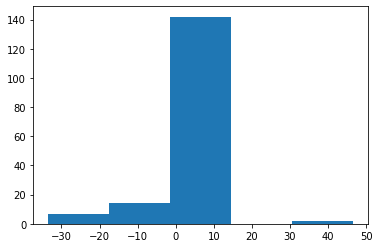

In [70]:
plt.hist(b[0][:, 4], bins=5)
plt.show()

In [59]:
# Convert a[0] to dataframe
df = pd.DataFrame(a[0], columns=['buy_time', 'buy_price', 'sell_time', 'sell_price', 'profit_loss', 'current_balance'])
df.to_csv('trades.csv')

In [ ]:
# Trading logic:-
# 1. Take profit at 1% or above. Wait a maximum of 2 days for this to happen.
# 2. If the trade is not closed in the above case, then sell it at stop loss 3% or below. Wait a maximum of 3 days for this to happen.
# 3. If below 3% stop loss is not possible, then move the trade to a list of trades on hold.
# 4. Try to sell this trades on hold at a loss of 7% or below.

# TimeFrame - Action
# 0 - 2 days - Take profit at 1% or above.
# 3 - 5 days - Sell at stop loss 3% or below.
# >= 5 days - Sell at loss of 7% or below.

In [ ]:
# Considering all of these parameters, can I do some sort of grid search to maximize the profit?
# Try experimenting with different time periods, different currency pairs
# Try deploying it in a real time environment but with demo account balance.
# Try using freqtade algo trading platform. (https://freqtrade.readthedocs.io/en/latest/index.html)
# Try using alpaca trading platform. (https://alpaca.markets/docs/api-documentation/introduction/)
# Try blankly tool from reddit.

In [ ]:
from naive_bot import NaiveBot

bot1 = NaiveBot(price_data)
bot1.perform_backtest(short=0, take_profit_percentage=1, selling_points=[(2, 3), (5, 7)], compound=False)